Intalling the Chembl web service package so that we can retrieve bioactivity data from the database

In [5]:
! pip install chembl_webresource_client

In [6]:
#import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client

In [9]:
#target search for coronavirus
target = new_client.target
target_query = target.search('coronavirus')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,15.0,False,CHEMBL612575,[],ORGANISM,227859
2,[],Feline coronavirus,Feline coronavirus,15.0,False,CHEMBL612744,[],ORGANISM,12663
3,[],Human coronavirus 229E,Human coronavirus 229E,13.0,False,CHEMBL613837,[],ORGANISM,11137
4,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
5,[],Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
6,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,4.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859
7,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,4.0,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049


In [ ]:
#select and retrive bioactivity data for SARS coronavirus 3C-like proteinase

In [11]:
selected_target = targets.target_chembl_id[4]
selected_target

'CHEMBL3927'

In [12]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [13]:
df = pd.DataFrame.from_dict(res)

In [14]:
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,single protein format,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '18.28', 'le': '0.33', 'lle': '3.25', ...",CHEMBL187579,None,CHEMBL187579,5.14,False,http://www.openphacts.org/units/Nanomolar,384103,=,1,True,=,None,IC50,nM,None,7200.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '12.10', 'le': '0.33', 'lle': '1.22', ...",CHEMBL188487,None,CHEMBL188487,5.03,False,http://www.openphacts.org/units/Nanomolar,383984,=,1,True,=,None,IC50,nM,None,9400.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '11.56', 'le': '0.29', 'lle': '2.21', ...",CHEMBL185698,None,CHEMBL185698,4.87,False,http://www.openphacts.org/units/Nanomolar,384106,=,1,True,=,None,IC50,nM,None,13500.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5
3,None,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '16.64', 'le': '0.32', 'lle': '1.25', ...",CHEMBL426082,None,CHEMBL426082,4.88,False,http://www.openphacts.org/units/Nanomolar,384075,=,1,True,=,None,IC50,nM,None,13110.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.11
4,None,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '16.84', 'le': '0.32', 'lle': '2.16', ...",CHEMBL187717,None,CHEMBL187717,5.70,False,http://www.openphacts.org/units/Nanomolar,384234,=,1,True,=,None,IC50,nM,None,2000.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,None,12041507,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,None,None,BAO_0000190,BAO_0000019,assay format,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,None,None,CHEMBL2146458,Bioorg. Med. Chem.,2012,"{'bei': '14.70', 'le': '0.27', 'lle': '1.57', ...",CHEMBL2146517,METHYL TANSHINONATE,CHEMBL2146517,4.97,False,http://www.openphacts.org/units/Nanomolar,1727226,=,1,True,=,None,IC50,nM,None,10600.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_000

In [16]:
df.standard_type.unique()

array(['IC50'], dtype=object)

In [17]:
df.to_csv('bioactivity_data.csv', index=False)

In [21]:
#if any compounds have missing value for the standard_value column then drop it
df.standard_value.isnull().any()

False

In [23]:
#labeling compounds as either beign active, inactive or intermediate
bioactivity_class = []
for i in df.standard_value:
  if float(i) >= 10000:
    bioactivity_class.append('inactive')
  elif float(i) <= 1000:
    bioactivity_class.append('active')
  else:
    bioactivity_class.append('intermediate')

In [29]:
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
new_df = df[selection]
new_df

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0
...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0


In [55]:
new_df = pd.concat([new_df, pd.Series(bioactivity_class)], axis=1)

In [31]:
new_df.to_csv('bioactivity_data_preprocessed.csv', index=False)

#Part2

In [32]:
#Install conda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-06-25 19:53:06--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   176MB/s    in 0.5s    

2021-06-25 19:53:07 (176 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [50]:
#calculating Lipinski descriptors
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [49]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [51]:
df_lipinski = lipinski(new_df.canonical_smiles)

In [52]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0
...,...,...,...,...
128,338.359,3.40102,0.0,5.0
129,296.366,3.44330,0.0,3.0
130,276.291,4.09564,0.0,3.0
131,278.307,3.29102,0.0,3.0


In [56]:
df_combined = pd.concat([new_df, df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,0,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0.0,5.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive,338.359,3.40102,0.0,5.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive,296.366,3.44330,0.0,3.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive,276.291,4.09564,0.0,3.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive,278.307,3.29102,0.0,3.0


In [63]:
df_combined = df_combined.rename(columns = {0:'bioactivity_class'})

In [64]:
df_combined.columns

Index(['molecule_chembl_id', 'canonical_smiles', 'standard_value',
       'bioactivity_class', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors'],
      dtype='object')

In [65]:
#converting IC50 to pIC50
def pIC50(input):
  pIC50 = []

  for i in input['standard_value_norm']:
    molar = i*(10**-9)
    pIC50.append(-np.log10(molar))

  input['pIC50'] = pIC50
  x = input.drop('standard_value_norm', 1)

  return x

In [66]:
df_combined.standard_value.describe()

count          133
unique          96
top       200000.0
freq             5
Name: standard_value, dtype: object

In [75]:
def norm_value(input):
    norm = []

    for i in pd.to_numeric(input['standard_value']):
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [76]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,2000.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,10600.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,10100.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,11500.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,10700.0


In [77]:
df_norm.describe()

,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
count,133.000000,133.000000,133.000000,133.000000,1.330000e+02
mean,376.392692,3.908219,0.909774,5.248120,2.110164e+07
std,87.221623,1.385540,0.882993,2.072204,4.089714e+07
min,204.185000,-0.055400,0.000000,2.000000,5.000000e+01
25%,296.366000,3.220320,0.000000,3.000000,1.070000e+04
50%,369.515000,3.769900,1.000000,5.000000,2.350000e+04
75%,437.437000,4.667120,2.000000,6.000000,3.000000e+05
max,588.635000,7.051540,3.000000,12.000000,1.000000e+08


In [79]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


In [81]:
df_final.pIC50.describe()

count    133.000000
mean       4.060148
std        1.783762
min        1.000000
25%        3.522879
50%        4.628932
75%        4.970616
max        7.301030
Name: pIC50, dtype: float64

In [86]:
#removing intermediate bioactivity class
df_2class = df_final[df_final.bioactivity_class != 'intermediate']

In [87]:
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,372.243,4.39330,0.0,3.0,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,419.243,4.23540,0.0,3.0,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


In [90]:
#exploring data analysis(chemical space analysis) via Lipinski descriptors
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

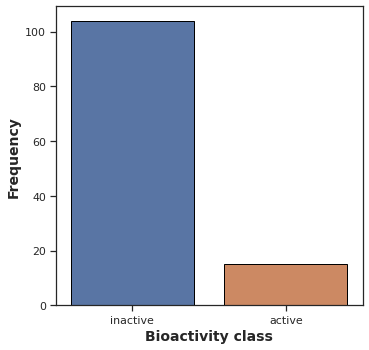

In [91]:
#frequency plot of the 2 bioavtivity classes
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

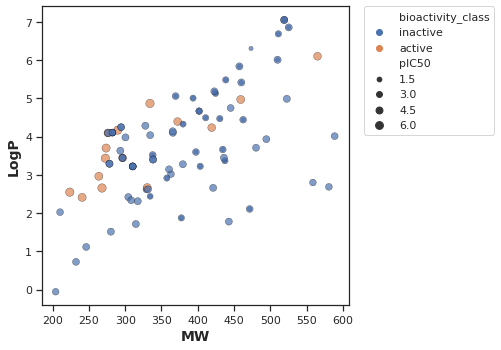

In [92]:
#Scatter plot of MW versus LogP
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

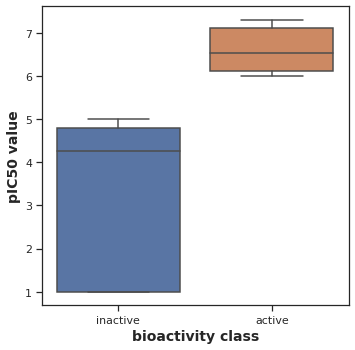

In [95]:
#boxplot-pIC50 value

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [97]:
#Statistical analysis | Mann-Whitney U Test
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df['bioactivity_class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df['bioactivity_class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

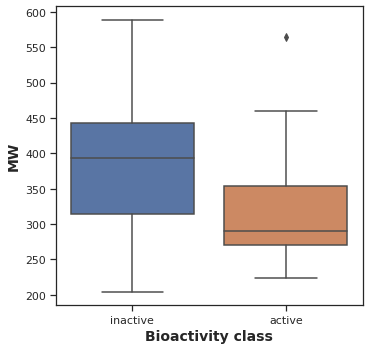

In [99]:

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

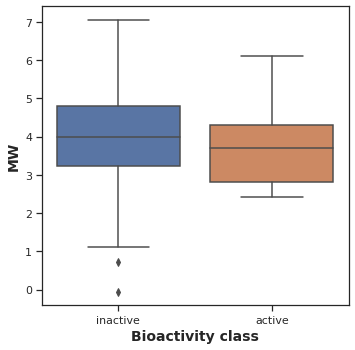

In [101]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

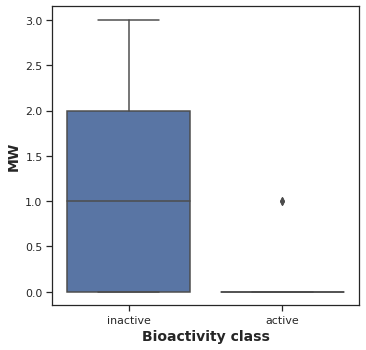

In [103]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

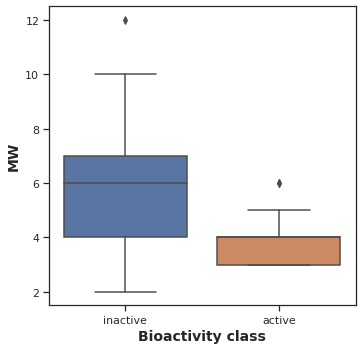

In [106]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [109]:
print(mannwhitney('NumHAcceptors'))
print(mannwhitney('NumHDonors'))
print(mannwhitney('pIC50'))
print(mannwhitney('MW'))
print(mannwhitney('LogP'))

      Descriptor  Statistics  ...  alpha                      Interpretation
0  NumHAcceptors       415.0  ...   0.05  Different distribution (reject H0)

[1 rows x 5 columns]
   Descriptor  Statistics         p  alpha                      Interpretation
0  NumHDonors       299.5  0.000024   0.05  Different distribution (reject H0)
  Descriptor  Statistics  ...  alpha                      Interpretation
0      pIC50         0.0  ...   0.05  Different distribution (reject H0)

[1 rows x 5 columns]
  Descriptor  Statistics         p  alpha                      Interpretation
0         MW       409.5  0.001525   0.05  Different distribution (reject H0)
  Descriptor  Statistics  ...  alpha                         Interpretation
0       LogP       712.5  ...   0.05  Same distribution (fail to reject H0)

[1 rows x 5 columns]


In [110]:
#Taking a look at pIC50 values, the actives and inactives displayed statistically significant difference,
# which is to be expected since threshold values 
#(IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives, 
#corresponding to pIC50 > 6 = Actives and pIC50 < 5 = Inactives) 
#were used to define actives and inactives.

In [111]:
! zip -r results.zip . -i *.csv *.pdf

  adding: mannwhitneyu_MW.csv (deflated 9%)
  adding: plot_MW_vs_LogP.pdf (deflated 15%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 12%)
  adding: mannwhitneyu_LogP.csv (deflated 7%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: bioactivity_data.csv (deflated 90%)
  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: bioactivity_data_preprocessed.csv (deflated 78%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 9%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: plot_MW.pdf (deflated 38%)
